In [17]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate, gate_sequence_product, Measurement, CircuitSimulator
from sync_calcs3 import calculate_steady_state, spin_husimi_qfunc, spin_S_measure

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode

# Gates

## IBM Q Gates

In [2]:
def U3(args):
    theta, phi, lambda_ = args
    matrix = [
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * lambda_ + 1j * phi) * np.cos(theta / 2)],
    ]
    return Qobj(matrix, dims=[[2], [2]])


In [3]:
def U2(args):
    phi, lambda_ = args
    return U3([np.pi/2, phi, lambda_])

In [4]:
def U1(lambda_):
    return U3([0,0,lambda_])

In [5]:
def CU3(args):
    mat = np.zeros((4, 4), dtype=complex)
    mat[0, 0] = mat[1, 1] = 1.0
    mat[2:4, 2:4] = U3(args)

    return Qobj(mat, dims=[[2, 2], [2, 2]])

CU3([1, 0, 0])


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.87758256 -0.47942554]
 [ 0.          0.          0.47942554  0.87758256]]

In [6]:

sz = jmat(.5,'z')
sy = jmat(.5,'y')
i = 1j
dt = 0.05


def U_unitary(args):
    detuning,signal_strength = args
    mat = np.zeros((2, 2), dtype=complex)
    Uz = (-0.5*detuning*i*sz*dt).expm()
    Uy = (-1*signal_strength*i*sy*dt).expm()
    U_unitary = (Uz*Uy*Uz)
    mat[0:2,0:2] = U_unitary[0:2, 0:2]

    return Qobj(mat, dims=[[2, 2], [2, 2]])


def CU_unitary(args):
    detuning,signal_strength,R = args
    mat = np.zeros((4, 4), dtype=complex)
    mat[0, 0] = mat[1, 1] = 1.0

    U_unitaryR = (U_unitary([detuning, signal_strength]))**R
    
    mat[2:4, 2:4] = U_unitaryR[0:2, 0:2]

    return Qobj(mat, dims=[[2, 2], [2, 2]])

CU_unitary([.5,1,1])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.99960942-0.01249577j
  -0.0249974 +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.0249974 +0.j
   0.99960942+0.01249577j]]

## Unitary Evo

In [7]:
def U(args):
    delta, epsilon, dt = args
    Rz = (1j * delta * sigmaz() * dt /2 ).expm()
    Ry = (1j * epsilon * sigmay() * dt).expm()
    return Rz * Ry * Rz

# Circuit

In [8]:
dt = .05

delta = np.pi/2
epsilon = 2

Gamma = 1.5
theta = 2*np.arcsin(np.sqrt(Gamma * dt))

In [9]:
qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "Uevo": U}, num_cbits=1)

## Unitary Gates

In [10]:
qc.add_gate("Uevo", arg_value=[delta, epsilon, dt])

## Relaxation

In [11]:
def reset(reg, bit, new):
    """Reset the qubit at position bit of reg with dm new"""
    traces = [reg.ptrace(i) for i in range(int(np.log2(reg.shape[0])))]

    traces[bit] = ket2dm(new) if new.type == "ket" else new
    return tensor(traces)


In [12]:
qc.add_gate("CU3", arg_value=[theta, 0, 0])
#qc.add_gate("CU_unitary", arg_value=[0,1,1])
qc.add_gate("CNOT", targets=[0], controls=[1])
qc.add_measurement("M", [1], classical_store=0)

In [13]:
p = qc.propagators()

# Doesn't include the measurement or reset
D = gate_sequence_product(p)
D 

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.9919369 +0.07806713j  0.        +0.j          0.09983342+0.j
   0.        +0.j        ]
 [-0.02734051+0.j         -0.09601671+0.j          0.27165311-0.02137956j
   0.95401436-0.07508256j]
 [-0.09601671+0.j          0.02734051+0.j          0.95401436-0.07508256j
  -0.27165311+0.02137956j]
 [ 0.        +0.j          0.9919369 +0.07806713j  0.        +0.j
   0.09983342+0.j        ]]

# Simulation

(array([[ 0.78298734+0.j        , -0.08137975-0.34088269j],
        [-0.08137975+0.34088269j,  0.21701266+0.j        ]]),
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 0.79225793+0.j         -0.08251163-0.33168567j]
  [-0.08251163+0.33168567j  0.20774207+0.j        ]])

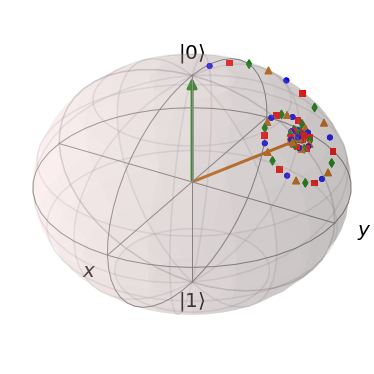

In [18]:
initial_state = tensor(basis(2, 0), basis(2, 0)) 

##tensor(((basis(2, 0) + basis(2,1)).unit()) , ((basis(2, 0) + basis(2,1)).unit())) 


b = Bloch()
b.add_states(initial_state.ptrace(0))

# sim = CircuitSimulator(qc, mode="density_matrix_simulator")

# final = sim.run(initial_state).get_final_states()[0]
# b.add_states(final.ptrace(0))

# for _ in range(10):
#     final = sim.run(final).get_final_states()[0]
#     b.add_states(final.ptrace(0))


for _ in range(100):
    result = qc.run(state=initial_state)
    reset_result = reset(result, 1, basis(2,0))

    b.add_states(reset_result.ptrace(0),kind="point")

    initial_state = reset_result
    final_state = reset_result
    
state = calculate_steady_state(gain_amp=0, loss_amp=Gamma, signal_strength=epsilon, detuning=delta)
s = state.full()
s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
state = Qobj(s)

b.add_states(state)    
b.show()


state.full() , reset_result.ptrace(0)

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1e6bfb56c70>)

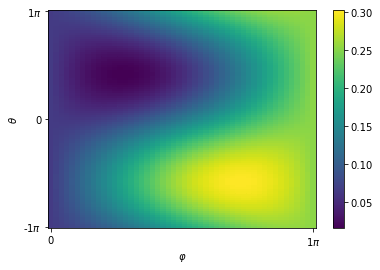

In [19]:
from sync_calcs3 import spin_husimi_qfunc
from sync_plots import plot_spin_qfunc

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

Q = spin_husimi_qfunc(initial_state.ptrace(0), theta, phi, method="qutip")
plot_spin_qfunc(Q.T, phi, theta)

(<matplotlib.contour.QuadContourSet at 0x1e6beebaca0>,
 <Figure size 1080x360 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi|\\hat\\rho)$'>))

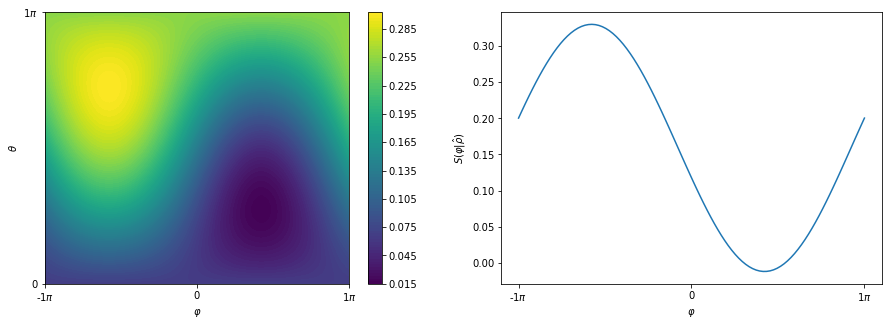

In [20]:
from sync_calcs3 import spin_husimi_qfunc, spin_S_measure
from sync_plots3 import plot_Q_and_S

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

Q = spin_husimi_qfunc(initial_state.ptrace(0), theta, phi, method="qutip")
S = spin_S_measure(theta, Q)

plot_Q_and_S(theta, phi, Q.T, S)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sync_calcs3 import calculate_steady_state, spin_husimi_qfunc, spin_S_measure
from sync_plots import angle_xaxis

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode


In [86]:
# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

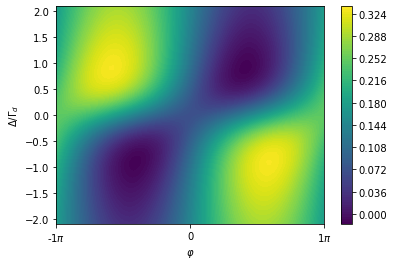

In [22]:
DR = np.pi
detunings = np.linspace(-DR, DR, n)

S = np.zeros([2*n, n])

for  i, delta in enumerate(detunings):
    
    dt = 0.05

    #delta = delta
    epsilon = 2

    Gamma = 1.5
    theta_ = 2*np.arcsin(np.sqrt(Gamma * dt))

    qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "Uevo": U}, num_cbits=1)
    qc.add_gate("Uevo", arg_value=[delta, epsilon, dt])

    def reset(reg, bit, new):
        """Reset the qubit at position bit of reg with dm new"""
        traces = [reg.ptrace(i) for i in range(int(np.log2(reg.shape[0])))]

        traces[bit] = ket2dm(new) if new.type == "ket" else new
        return tensor(traces)


    qc.add_gate("CU3", arg_value=[theta_, 0, 0])
    #qc.add_gate("CU_unitary", arg_value=[0,1,1])
    qc.add_gate("CNOT", targets=[0], controls=[1])
    qc.add_measurement("M", [1], classical_store=0)
    
    
    p = qc.propagators()

    # Doesn't include the measurement or reset
    D = gate_sequence_product(p)
    D 
    
    initial_state = tensor(basis(2, 0), basis(2, 0)) 

    ##tensor(((basis(2, 0) + basis(2,1)).unit()) , ((basis(2, 0) + basis(2,1)).unit())) 


    #b = Bloch()
    #b.add_states(initial_state.ptrace(0))

    # sim = CircuitSimulator(qc, mode="density_matrix_simulator")

    # final = sim.run(initial_state).get_final_states()[0]
    # b.add_states(final.ptrace(0))

    # for _ in range(10):
    #     final = sim.run(final).get_final_states()[0]
    #     b.add_states(final.ptrace(0))


    for _ in range(300):
        result = qc.run(state=initial_state)
        reset_result = reset(result, 1, basis(2,0))

        #b.add_states(reset_result.ptrace(0),kind="point")

        initial_state = reset_result
        new_state = initial_state.ptrace(0)
        
    n = 50  # angle array size scale

    theta = np.linspace(0, np.pi, n)
    phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)
    
    Q = spin_husimi_qfunc(new_state, theta, phi, method="qutip")
    s = spin_S_measure(theta, Q)

    S[:, i] = s
    
    
fig, ax = plt.subplots()

DETUNING, PHI = np.meshgrid(detunings / Gamma, phi)

cquad = ax.contourf(PHI, DETUNING, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

<ipython-input-361-e10f7d19af14>:16: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "Uevo": U}, num_cbits=1)
<ipython-input-361-e10f7d19af14>:36: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  D = gate_sequence_product(p)


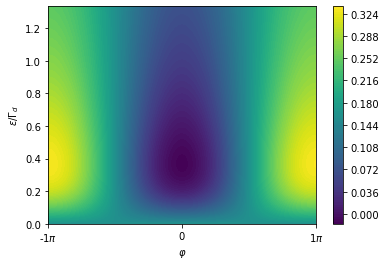

In [361]:
ER = 2
strengths = np.linspace(0, ER, n)

S = np.zeros([2*n, n])

for  i, epsilon in enumerate(strengths):
    
    dt = .05

    delta = 0
    #epsilon = 1

    Gamma = 1.5
    theta_ = 2*np.arcsin(np.sqrt(Gamma * dt))

    qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "Uevo": U}, num_cbits=1)
    qc.add_gate("Uevo", arg_value=[delta, epsilon, dt])

    def reset(reg, bit, new):
        """Reset the qubit at position bit of reg with dm new"""
        traces = [reg.ptrace(i) for i in range(int(np.log2(reg.shape[0])))]

        traces[bit] = ket2dm(new) if new.type == "ket" else new
        return tensor(traces)


    qc.add_gate("CU3", arg_value=[theta_, 0, 0])
    #qc.add_gate("CU_unitary", arg_value=[0,1,1])
    qc.add_gate("CNOT", targets=[0], controls=[1])
    qc.add_measurement("M", [1], classical_store=0)
    
    
    p = qc.propagators()

    # Doesn't include the measurement or reset
    D = gate_sequence_product(p)
    D 
    
    initial_state = tensor(basis(2, 0), basis(2, 0)) 

    ##tensor(((basis(2, 0) + basis(2,1)).unit()) , ((basis(2, 0) + basis(2,1)).unit())) 


    #b = Bloch()
    #b.add_states(initial_state.ptrace(0))

    # sim = CircuitSimulator(qc, mode="density_matrix_simulator")

    # final = sim.run(initial_state).get_final_states()[0]
    # b.add_states(final.ptrace(0))

    # for _ in range(10):
    #     final = sim.run(final).get_final_states()[0]
    #     b.add_states(final.ptrace(0))


    for _ in range(300):
        result = qc.run(state=initial_state)
        reset_result = reset(result, 1, basis(2,0))

        #b.add_states(reset_result.ptrace(0),kind="point")

        initial_state = reset_result
        new_state = initial_state.ptrace(0)
        
    n = 50  # angle array size scale

    theta = np.linspace(0, np.pi, n)
    phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)
    
    Q = spin_husimi_qfunc(new_state, theta, phi, method="qutip")
    s = spin_S_measure(theta, Q)

    S[:, i] = s
    
    
fig, ax = plt.subplots()

STRENGTHS, PHI = np.meshgrid(strengths / Gamma , phi)

cquad = ax.contourf(PHI, STRENGTHS, S, 2*n)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

In [ ]:
n = 50

DR = np.pi
detunings = np.linspace(-DR, DR, n)

ER = 2
strengths = np.linspace(0, ER, n)
Smax = np.zeros([2 * n, n])

from utils import profile

# @profile

for i, delta in enumerate(detunings):
    for j, epsilon in enumerate(strengths):
            
            dt = 0.05
            Gamma = 2
            theta_ = 2*np.arcsin(np.sqrt(Gamma * dt))

            qc = QubitCircuit(2, user_gates={"U3": U3, "CU3": CU3, "Uevo": U}, num_cbits=1)
            qc.add_gate("Uevo", arg_value=[delta, epsilon, dt])

            def reset(reg, bit, new):
                """Reset the qubit at position bit of reg with dm new"""
                traces = [reg.ptrace(i) for i in range(int(np.log2(reg.shape[0])))]

                traces[bit] = ket2dm(new) if new.type == "ket" else new
                return tensor(traces)


            qc.add_gate("CU3", arg_value=[theta_, 0, 0])
            #qc.add_gate("CU_unitary", arg_value=[0,1,1])
            qc.add_gate("CNOT", targets=[0], controls=[1])
            qc.add_measurement("M", [1], classical_store=0)
    
    
            p = qc.propagators()

            # Doesn't include the measurement or reset
            D = gate_sequence_product(p)
            D 
    
            initial_state = tensor(basis(2, 0), basis(2, 0)) 

    ##tensor(((basis(2, 0) + basis(2,1)).unit()) , ((basis(2, 0) + basis(2,1)).unit())) 


    #b = Bloch()
    #b.add_states(initial_state.ptrace(0))

    # sim = CircuitSimulator(qc, mode="density_matrix_simulator")

    # final = sim.run(initial_state).get_final_states()[0]
    # b.add_states(final.ptrace(0))

    # for _ in range(10):
    #     final = sim.run(final).get_final_states()[0]
    #     b.add_states(final.ptrace(0))


            for _ in range(1):
                result = qc.run(state=initial_state)
                reset_result = reset(result, 1, basis(2,0))

        #b.add_states(reset_result.ptrace(0),kind="point")

                initial_state = reset_result
                new_state = initial_state.ptrace(0)
        
            n = 50  # angle array size scale

            theta = np.linspace(0, np.pi, n)
            phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)
    
            Q = spin_husimi_qfunc(new_state, theta, phi, method="qutip")
            s = spin_S_measure(theta, Q)

            Smax[i, j] = np.max(s)
    
    

fig, ax = plt.subplots()

DETUNINGS, STRENGTHS  = np.meshgrid(detunings , strengths ) # / loss amp

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 2*n)
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)

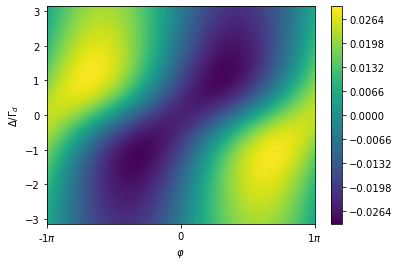

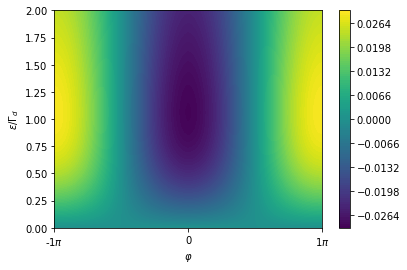

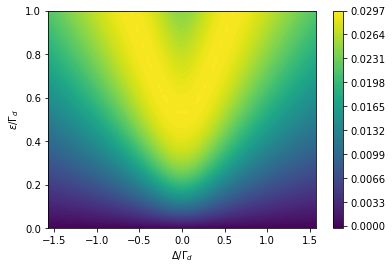

In [362]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from sync_calcs3 import calculate_steady_state, spin_husimi_qfunc, spin_S_measure
from sync_plots import angle_xaxis

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode

# Plotting constants
n = 50  # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2 * n).reshape(-1, 1)  # 1D vector -> 2D column vector

gain_amp=1
loss_amp=2

DR = np.pi
detunings = np.linspace(-DR, DR, n)


S = np.zeros([2*n, n])

for i, D in enumerate(detunings):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=loss_amp, detuning=D)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s
    
fig, ax = plt.subplots()

DETUNING, PHI = np.meshgrid(detunings , phi) # / loss_amp

cquad = ax.contourf(PHI, DETUNING, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

ER = 2
strengths = np.linspace(0, ER, n)

S = np.zeros([2*n, n])

for i, E in enumerate(strengths):
    state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=0)
    s = state.full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s
    
fig, ax = plt.subplots()

STRENGTHS, PHI = np.meshgrid(strengths, phi) # / loss_amp

cquad = ax.contourf(PHI, STRENGTHS, S, 100)
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)
angle_xaxis(ax)

n = 50

DR = np.pi
detunings = np.linspace(-DR, DR, 2*n)

ER = 2
strengths = np.linspace(0, ER, n)
Smax = np.zeros([2 * n, n])

from utils import profile

# @profile
def calc():
    for i, D in enumerate(detunings):
        for j, E in enumerate(strengths):
            state = calculate_steady_state(gain_amp=gain_amp, loss_amp=loss_amp, signal_strength=E, detuning=D)
            s = state.full()
            s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
            s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
            Q = spin_husimi_qfunc(state, theta, phi)
            s = spin_S_measure(theta, Q)

            Smax[i, j] = np.max(s)

calc()
fig, ax = plt.subplots()

DETUNINGS, STRENGTHS  = np.meshgrid(detunings / loss_amp, strengths / loss_amp)

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 100)
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

fig.colorbar(cquad)